In [1]:
import sopa
import sopa.io
import sopa.segmentation
from sopa.segmentation.transcripts import resolve
from sopa.segmentation.methods import comseg_patch

# ComSeg segmentation

[ComSeg](https://github.com/fish-quant/ComSeg) is a transcript-based segmentation method. It uses a segmentation prior (here, Cellpose) and improves it using the transcripts information.

## 1. Running Cellpose as a prior

In [2]:
### load data
image_key = "image"
points_key = "transcripts"
gene_column = "genes" # (optional) column of sdata[points_key] containing the gene names

sdata = sopa.io.uniform()


patches = sopa.segmentation.Patches2D(sdata, image_key, patch_width=1200, patch_overlap=50)
patches.write()

channels = ["DAPI"]
method = sopa.segmentation.methods.cellpose_patch(diameter=35, channels=channels, flow_threshold=2, cellprob_threshold=-6)
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=2500)

# The cellpose boundaries will be temporary saved here. You can choose a different path
cellpose_temp_dir = "tuto.zarr/.sopa_cache/cellpose"
segmentation.write_patches_cells(cellpose_temp_dir)

cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)

shapes_key = "cellpose_boundaries" # name of the key given to the cells in sdata.shapes
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key, shapes_key)

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell
[INFO] (sopa.patches.patches) 4 patches were saved in sdata['sopa_patches']
[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Reading patches: 100%|██████████| 4/4 [00:00<00:00, 107.39it/s]
[INFO] (sopa.segmentation.stainings) Found 388 total cells
Resolving conflicts: 100%|██████████| 68/68 [00:00<00:00, 9442.88it/s]
[INFO] (sopa.segmentation.stainings) Added 367 cell boundaries in sdata['cellpose_boundaries']


## 2. Creating ComSeg inputs

In [3]:
temp_dir = "tuto.zarr/.sopa_cache/comseg"

patches = sopa.segmentation.Patches2D(sdata, points_key, patch_width=200, patch_overlap=50)

valid_indices = patches.patchify_transcripts(temp_dir, use_prior=True, min_transcripts_per_patch=1000)
valid_indices2 = patches.patchify_centroids(temp_dir)

[INFO] (sopa.patches.patches) Writing sub-CSV for transcript segmentation


[########################################] | 100% Completed | 374.58 ms


[INFO] (sopa.patches.patches) Patches saved in directory tuto.zarr/.sopa_cache/comseg
[INFO] (sopa.patches.patches) Writing sub-CSV for transcript segmentation
[INFO] (sopa.patches.patches) Patches saved in directory tuto.zarr/.sopa_cache/comseg


## 3. Running ComSeg on each patch

In [ ]:
config =  {
    "dict_scale" : {"x": 1, 'y': 1, "z": 1},
    "mean_cell_diameter" : 15,
    "max_cell_radius": 50,
    "alpha" :  0.5,
    "min_rna_per_cell" : 5,
    "gene_column" : "genes",
}

for patch_index in valid_indices:
    comseg_patch(temp_dir, patch_index, config)

## 4. Resolve segmentation and aggregate

In [5]:
shapes_key = "comseg_boundaries"

resolve(sdata, temp_dir, gene_column, min_area=10, shapes_key=shapes_key)

aggregator = sopa.segmentation.Aggregator(sdata, image_key=image_key, shapes_key=shapes_key)
aggregator.compute_table(gene_column=gene_column, average_intensities=True)


[INFO] (sopa.segmentation.transcripts) Cells whose area is less than 10 microns^2 will be removed
Resolving conflicts: 100%|██████████| 532/532 [00:00<00:00, 8834.13it/s]
[INFO] (sopa.segmentation.transcripts) Aggregating transcripts on merged cells
[INFO] (sopa.segmentation.aggregate) Aggregating transcripts over 155 cells


[########################################] | 100% Completed | 104.68 ms


[INFO] (sopa.segmentation.transcripts) Added sdata.tables['table'], and 367 cell boundaries to sdata['comseg_boundaries']
[INFO] (sopa.segmentation.aggregate) Using existing table for aggregation
[WARNING] (sopa.segmentation.aggregate) sdata.table is already existing. Transcripts are not count again.
[INFO] (sopa.segmentation.aggregate) Averaging channels intensity over 367 cells with expansion 0.0


[########################################] | 100% Completed | 106.14 ms


/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:92: UserWarning: Key `comseg_boundaries` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


## 5. Check the segmentation

In [6]:
import spatialdata_plot

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:102: UserWarning: Key `transcripts` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata_plot/pl/render.py:320: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


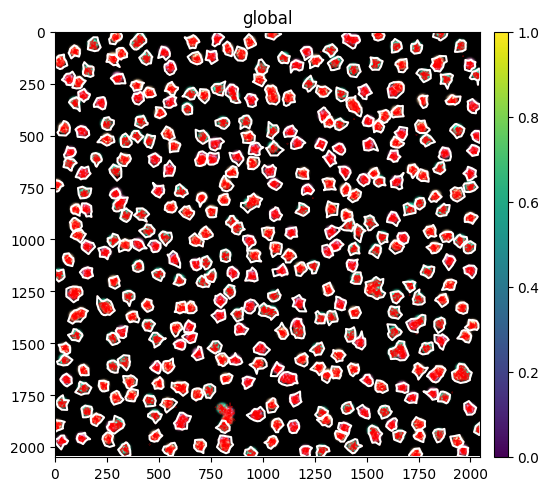

In [7]:
sdata\
    .pl.render_points(size=0.01, color="r")\
    .pl.render_images()\
    .pl.render_shapes(shapes_key, outline=True, fill_alpha=0, outline_color="w")\
    .pl.show("global")

You can also use the Xenium Explorer:

In [8]:
sopa.io.write("tuto.explorer", sdata, image_key, points_key="transcripts", gene_column=gene_column, shapes_key="comseg_boundaries")

[INFO] (sopa.io.explorer.table) Writing table with 5 columns
[INFO] (sopa.io.explorer.table) Writing 2 cell categories: region, slide
[INFO] (sopa.io.explorer.shapes) Writing 367 cell polygons
[INFO] (sopa.io.explorer.points) Writing 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 0: 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 1: 10000 transcripts
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (4, 2048, 2048)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 2048, 2048)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 1024, 1024)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 512, 512)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 256, 256)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 128, 128)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 64, 64)
[INFO] (sopa.